In [1]:
using OrdinaryDiffEq, ParameterizedFunctions
using Optim, LsqFit
using Plots, LaTeXStrings
using DelimitedFiles
using DataFrames
using Statistics
using Printf

In [2]:
ENV["COLUMNS"]=120
figdir = "figures/";

In [3]:
function print_fit_values(fit, par0, par_names, alpha=0.1)
    println(@sprintf "RSS = %.5f (convergence: %s)" sum(abs2, fit.resid) fit.converged)
    for i in 1:length(par0)
        name = par_names[i]
        val = fit.param[i]
        CIl = confidence_interval(fit, alpha)[i][1]
        CIr = confidence_interval(fit, alpha)[i][2]
        p0 = par0[i]
        println(@sprintf "  %s = %.3e (CI=(%.3e, %.3e), initial=%.3e)" name val CIl CIr p0)
    end
end

print_fit_values (generic function with 2 methods)

# Fitting the Virus Load Function to the Virus-Target Model

Here we investigate how the Virus Load function

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where 

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$,

fits to the standard viral kinetic ODE model 
$$
\begin{aligned}
\frac{dT}{dt} & = -\beta T V, \\
\frac{dI_1}{dt} & = \beta T V - k I_1, \\
\frac{dI_2}{dt} & = k I_1 - \frac{\delta I_2}{K + I_2}, \\
\frac{dV}{dt} & = p I_2 -c V.
\end{aligned}
$$


In [4]:
function VirusLoadFunction(t, p)
    heaviside(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))
    v₁(t, a₁, a₂, logVmax) = 1. + (10^logVmax - 1.0)*(tanh(6.0*(t - (a₁ + a₂)/2)/(a₂ - a₁)) - tanh(-3.0*(a₂ + a₁)/(a₂ - a₁)))/2
    v₂(t, a₂, α) = 1. - heaviside(t - a₂) + heaviside(t - a₂)*exp(-α*(t - a₂))
    v₃(t, b₁, b₂, logVmin) = 1. - (1.0 - 10^logVmin)*(tanh(6.0*(t - (b₁ + b₂)/2)/(b₂ - b₁)) - tanh(-3.0*(b₂ + b₁)/(b₂ - b₁)))/2
    a₁, a₂, b₁, b₂, α, logVmin, logVmax = p
    log10.(v₁.(t, a₁, a₂, logVmax).*v₂.(t, a₂, α).*v₃.(t, b₁, b₂, logVmin))
end

VirusLoadFunction (generic function with 1 method)

In [5]:
VirusTargetODE = @ode_def begin
    dT = -β*T*V
    dI₁ = β*T*V - k*I₁
    dI₂ = k*I₁ - δ*I₂/(K + I₂)
    dV = p*I₂ - c*V
end β k δ K p c
u0 = [1e+7, 75.0, 0.0, 1e0]
tend = 9.0
tspan = (0.0, tend)
function VirusTargetModel(t, p)
    prob = ODEProblem(VirusTargetODE, u0, tspan, p)
    sol = solve(prob, Tsit5(), dtmax=1e-2)
    log10.(sol(t)[end, :])
end

VirusTargetModel (generic function with 1 method)

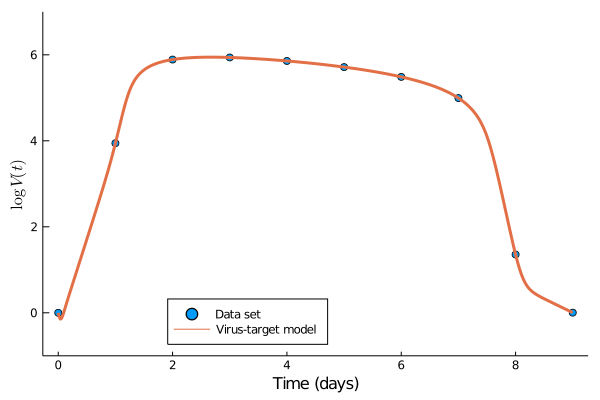

In [6]:
tend = 9.0
ttdata = Vector(range(0., tend, step=1.))
parsVTM = (β = 2.629e-04,
           k = 1.480e+00,
           δ = 1.593e+06,
           K = 7.899e+04,
           p = 2.090e+00,
           c = 1.505e+01)
vvdata = VirusTargetModel(ttdata, parsVTM)
pt = plot(ttdata, vvdata, 
    label="Data set", seriestype=:scatter)
tt = Vector(range(0., tend, step=1e-2))
plot!(pt, tt, VirusTargetModel(tt, parsVTM), lw=3,
    label="Virus-target model", 
    grid=:off, legend=:bottom,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
display(pt)

Now, let fit the Virus load function to the virus-target model.

In [7]:
#       a₁,   a₂,   b₁,   b₂,   α,    logVmin, logVmax
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, -6.0,    5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, -7.0,    4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, -2.0,    7.0]
fit = curve_fit(VirusLoadFunction, ttdata, vvdata, par0, lower=lb, upper=ub)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([0.7858327222016727, 2.807224774095687, 6.266351617375581, 7.655641624765401, 0.3450207245449596, -5.072667027594024, 6.0028377726689985], [0.0, 2.0975671122691608e-5, -0.00017336256999289645, 0.03553168000303586, -0.032929449190895355, -0.04026363677280553, 0.0378366003380437, -3.21996796337487e-5, 1.0023678342685471e-5, -6.291315034602854e-7], [0.0 0.0 … 0.0 0.0; -2.2811141788886578 -0.2741369559411718 … 0.0 0.9998873100869003; … ; 8.3586791045398e-5 0.14981719817351258 … 0.06262902977856602 0.9999999999890099; 8.358680049900304e-5 0.1498171981678744 … 0.9973529432452954 0.9999999999877572], true, Float64[])

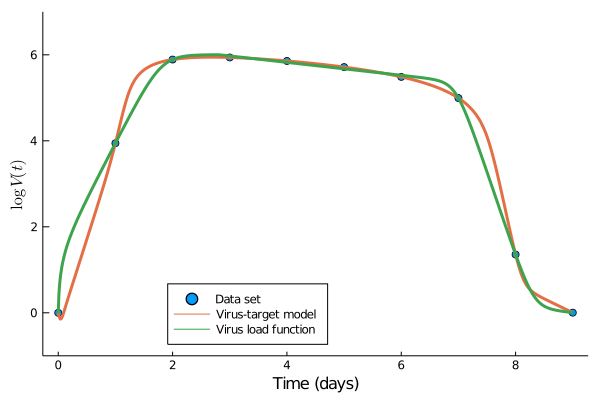

In [8]:
tt = Vector(range(0., tend, step=1e-2))
pt = plot(ttdata, vvdata, 
    label="Data set", seriestype=:scatter)
plot!(pt, tt, VirusTargetModel(tt, parsVTM), lw=3,
    label="Virus-target model")
plot!(pt, tt, VirusLoadFunction(tt, fit.param), lw=3,
    label="Virus load function", 
    grid=:off, legend=:bottom,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
display(pt)

In [9]:
par_names = ["a₁", "a₂", "b₁", "b₂", "α", "logVmin", "logVmax"]
print_fit_values(fit, par0, par_names)

RSS = 0.00540 (convergence: true)
  a₁ = 7.858e-01 (CI=(7.229e-01, 8.487e-01), initial=7.000e-01)
  a₂ = 2.807e+00 (CI=(2.527e+00, 3.088e+00), initial=2.880e+00)
  b₁ = 6.266e+00 (CI=(6.161e+00, 6.371e+00), initial=6.000e+00)
  b₂ = 7.656e+00 (CI=(7.602e+00, 7.709e+00), initial=7.600e+00)
  α = 3.450e-01 (CI=(2.419e-01, 4.481e-01), initial=2.000e-01)
  logVmin = -5.073e+00 (CI=(-5.303e+00, -4.842e+00), initial=-6.000e+00)
  logVmax = 6.003e+00 (CI=(5.931e+00, 6.075e+00), initial=5.000e+00)


Using more data points to see how the the virus load function fits overall.

In [10]:
tend = 9.0
ttdata = Vector(range(0., tend, step=0.1))
vvdata = VirusTargetModel(ttdata, parsVTM)
#       a₁,   a₂,   b₁,   b₂,   α,    logVmin, logVmax
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, -6.0,   5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, -7.0,    4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, -2.0,    7.0]
fit = curve_fit(VirusLoadFunction, ttdata, vvdata, par0, lower=lb, upper=ub)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([0.890240670714995, 2.053431812825089, 6.698892866057608, 7.7798850994538045, 0.35364325181049744, -4.8550184803287655, 6.052091618966296], [0.0, 0.1558377816634473, 0.016179225006673736, -0.02658940205392446, -0.025107380277644475, -0.005894652963416291, 0.018791992393213164, 0.04216897881611459, 0.05661525678354007, 0.04745129866925257  …  0.15124656900724243, 0.0542498735644209, -0.05570046003726126, -0.1024035506104452, -0.09469340814751112, -0.06096403582253837, -0.017301634224204915, 0.02984454298020639, 0.07817408790695256, 0.12690005673723675], [0.0 0.0 … 0.0 0.0; -2.4948377220421554 0.9659165143716758 … 0.0 0.3412497032769411; … ; 2.0126301142070193e-6 0.15358444027581034 … 0.9992940411723911 0.9999999999885874; 2.012632405990058e-6 0.15358444028027463 … 0.9997672698825789 0.9999999999897234], true, Float64[])

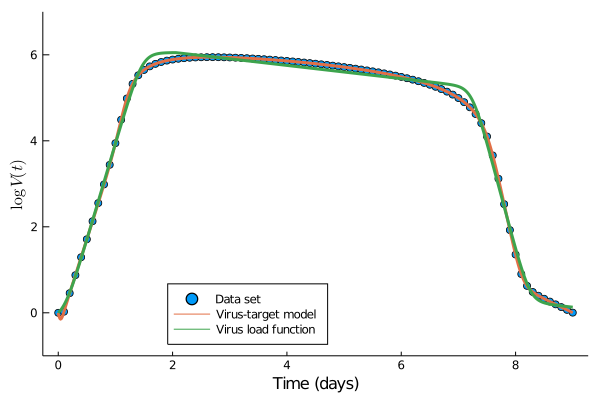

In [11]:
tt = Vector(range(0., tend, step=1e-2))
pt = plot(ttdata, vvdata, 
    label="Data set", seriestype=:scatter)
plot!(pt, tt, VirusTargetModel(tt, parsVTM), lw=3,
    label="Virus-target model")
plot!(pt, tt, VirusLoadFunction(tt, fit.param), lw=3,
    label="Virus load function", 
    grid=:off, legend=:bottom,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
savefig(figdir*"VLFVTMComparisson.png")
savefig(figdir*"VLFVTMComparisson.pdf")
display(pt)

The data fit is very accurate but the two functions differ in shape near the shoulders and the slope in the portion of slow decay.

In [12]:
print_fit_values(fit, par0, par_names)

RSS = 1.19584 (convergence: true)
  a₁ = 8.902e-01 (CI=(8.730e-01, 9.075e-01), initial=7.000e-01)
  a₂ = 2.053e+00 (CI=(2.004e+00, 2.103e+00), initial=2.880e+00)
  b₁ = 6.699e+00 (CI=(6.638e+00, 6.760e+00), initial=6.000e+00)
  b₂ = 7.780e+00 (CI=(7.760e+00, 7.800e+00), initial=7.600e+00)
  α = 3.536e-01 (CI=(3.137e-01, 3.936e-01), initial=2.000e-01)
  logVmin = -4.855e+00 (CI=(-4.967e+00, -4.743e+00), initial=-6.000e+00)
  logVmax = 6.052e+00 (CI=(6.006e+00, 6.098e+00), initial=5.000e+00)


As expected some of the values change if we include more data points.